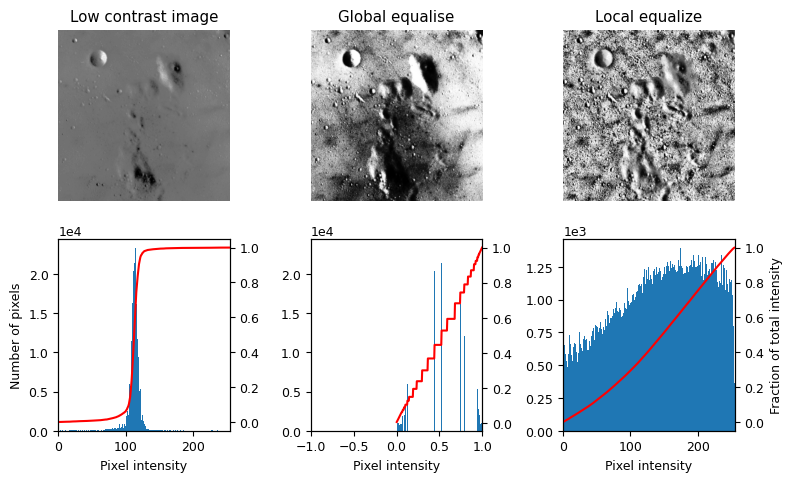

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def plot_img_and_hist(image, axes, bins=256):

    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()


    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf
img = img_as_ubyte(data.moon())
img_rescale = exposure.equalize_hist(img)
footprint = disk(30)
img_eq = rank.equalize(img, footprint=footprint)
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')
fig.tight_layout()

In [5]:
from argparse import ArgumentParser
from math import floor
from PIL import Image

import os


class Dither():
    def __init__(self, path, algorithm=None, output=None):
        self.path = self.get_path(path)
        self.algorithm = algorithm
        self.output = output
        self.func = self.get_func(self.algorithm)
        self.func(self.path)

    def get_path(self, path):
        if path.startswith('/') and not path.startswith('~/'):
            return os.getcwd() + '/' + path
        else:
            return path

    def get_func(self, algorithm):
        return self.floyd_steinberg_dither

    def apply_threshold(self, value):
        return 255 * floor(value/128)

    def floyd_steinberg_dither(self, image_file):
        new_img = Image.open(image_file)

        new_img = new_img.convert('RGB')
        pixel = new_img.load()

        x_lim, y_lim = new_img.size

        for y in range(1, y_lim):
            for x in range(1, x_lim):
                red_oldpixel, green_oldpixel, blue_oldpixel = pixel[x, y]

                red_newpixel = self.apply_threshold(red_oldpixel)
                green_newpixel = self.apply_threshold(green_oldpixel)
                blue_newpixel = self.apply_threshold(blue_oldpixel)

                pixel[x, y] = red_newpixel, green_newpixel, blue_newpixel

                red_error = red_oldpixel - red_newpixel
                blue_error = blue_oldpixel - blue_newpixel
                green_error = green_oldpixel - green_newpixel

                if x < x_lim - 1:
                    red = pixel[x+1, y][0] + round(red_error * 7/16)
                    green = pixel[x+1, y][1] + round(green_error * 7/16)
                    blue = pixel[x+1, y][2] + round(blue_error * 7/16)

                    pixel[x+1, y] = (red, green, blue)

                if x > 1 and y < y_lim - 1:
                    red = pixel[x-1, y+1][0] + round(red_error * 3/16)
                    green = pixel[x-1, y+1][1] + round(green_error * 3/16)
                    blue = pixel[x-1, y+1][2] + round(blue_error * 3/16)

                    pixel[x-1, y+1] = (red, green, blue)

                if y < y_lim - 1:
                    red = pixel[x, y+1][0] + round(red_error * 5/16)
                    green = pixel[x, y+1][1] + round(green_error * 5/16)
                    blue = pixel[x, y+1][2] + round(blue_error * 5/16)

                    pixel[x, y+1] = (red, green, blue)

                if x < x_lim - 1 and y < y_lim - 1:
                    red = pixel[x+1, y+1][0] + round(red_error * 1/16)
                    green = pixel[x+1, y+1][1] + round(green_error * 1/16)
                    blue = pixel[x+1, y+1][2] + round(blue_error * 1/16)

                    pixel[x+1, y+1] = (red, green, blue)

        if self.output:
            new_img.save(self.output)
        else:
            new_img.show()


def main():
    parser = ArgumentParser(description="Image dithering")
    parser.add_argument("image_path", help="input image location")
    parser.add_argument("-o", help="output image location")
    args = parser.parse_args()

    if args.image_path and not args.o:
        Dither(args.image_path)
    elif args.image_path and args.o:
        Dither(args.image_path, output=args.o)

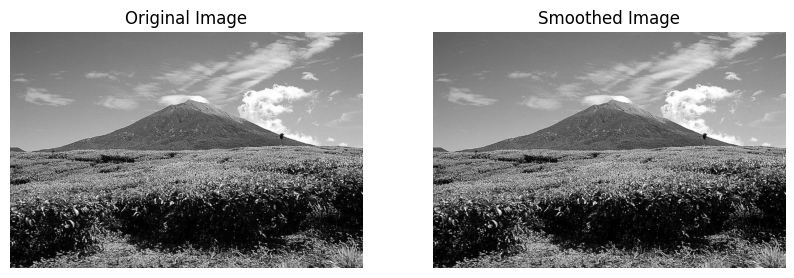

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

image = Image.open('D:\\MULANGA\\myproject\\photos\\matching.jpg')

image_gray = image.convert('L')

smoothed_image = image_gray.filter(ImageFilter.ModeFilter(size=3))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(smoothed_image, cmap='gray')
axes[1].set_title('Smoothed Image')
axes[1].axis('off')
plt.show()


In [7]:
# Importing Image and ImageFilter module from PIL package  
from PIL import Image, ImageFilter 
     
# creating a image object 
im1 = Image.open(r"D:\\MULANGA\\myproject\\photos\\matching.jpg") 
     
# applying the mode filter 
im2 = im1.filter(ImageFilter.ModeFilter(size = 3)) 
     
im2.show() 

[[[0.56078431 0.47058824 0.40784314]
  [0.56078431 0.47058824 0.40784314]
  [0.55294118 0.4627451  0.4       ]
  ...
  [0.17647059 0.10588235 0.05098039]
  [0.17647059 0.10588235 0.05098039]
  [0.17647059 0.10588235 0.05098039]]

 [[0.57254902 0.48235294 0.41960784]
  [0.56862745 0.47843137 0.41568627]
  [0.56078431 0.47058824 0.40784314]
  ...
  [0.18039216 0.11372549 0.05098039]
  [0.17647059 0.11372549 0.05098039]
  [0.18431373 0.11764706 0.05490196]]

 [[0.58039216 0.49411765 0.43921569]
  [0.57647059 0.49019608 0.43529412]
  [0.57254902 0.47843137 0.42745098]
  ...
  [0.18823529 0.10980392 0.06666667]
  [0.19215686 0.11372549 0.07058824]
  [0.19607843 0.11764706 0.0745098 ]]

 ...

 [[0.36078431 0.22745098 0.11764706]
  [0.41176471 0.27843137 0.16862745]
  [0.51764706 0.38431373 0.27843137]
  ...
  [0.6745098  0.56862745 0.54117647]
  [0.6745098  0.56862745 0.54117647]
  [0.6745098  0.56862745 0.54117647]]

 [[0.50196078 0.36078431 0.23529412]
  [0.54509804 0.40392157 0.27843137]


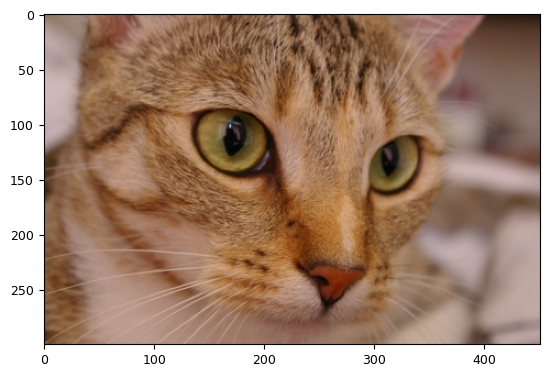

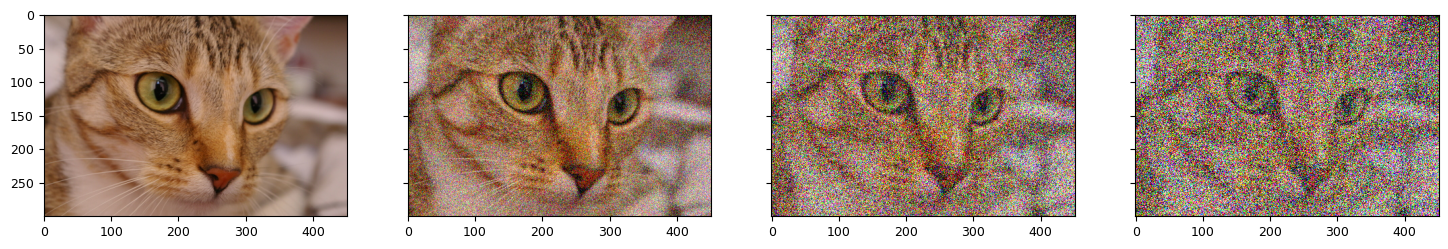

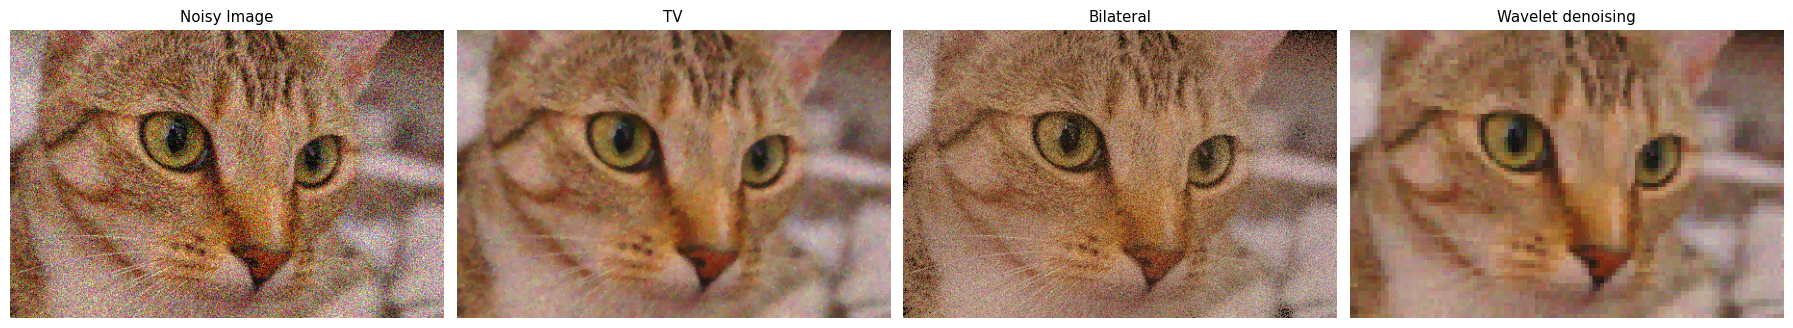

In [21]:
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.util import random_noise

original = img_as_float(data.chelsea())
plt.imshow(original)
print(original)
sigma = 0.155
noisy1 = random_noise(original, var=sigma**2)
noisy2 = random_noise(original, var=sigma**1)
noisy3 = random_noise(original, var=sigma**0.5)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 15), sharex=True, sharey=True)
ax[0].imshow(original)
ax[1].imshow(noisy1)
ax[2].imshow(noisy2)
ax[3].imshow(noisy3)
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)

fig, ax = plt.subplots(ncols=4, figsize=(18, 15),sharex=True, sharey=True)

plt.gray()

noisy_im = noisy1

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy_im, channel_axis=-1, average_sigmas=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0].imshow(noisy_im)
ax[0].axis('off')
ax[0].set_title('Noisy Image')

ax[1].imshow(denoise_tv_chambolle(noisy_im, weight=0.1, channel_axis=-1))
ax[1].axis('off')
ax[1].set_title('TV')

ax[2].imshow(denoise_bilateral(noisy_im, sigma_color=0.05, sigma_spatial=15, channel_axis=-1))
ax[2].axis('off')
ax[2].set_title('Bilateral')

ax[3].imshow(denoise_wavelet(noisy_im, channel_axis=-1, rescale_sigma=True))
ax[3].axis('off')
ax[3].set_title('Wavelet denoising')

fig.tight_layout()

plt.show()

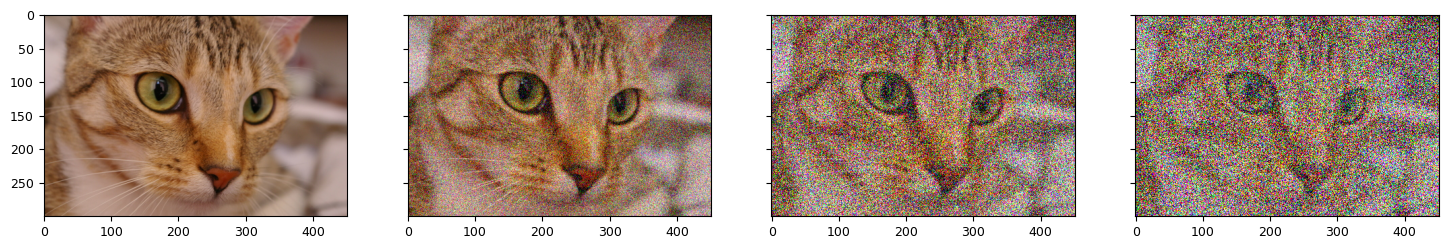

In [19]:
sigma = 0.155
noisy1 = random_noise(original, var=sigma**2)
noisy2 = random_noise(original, var=sigma**1)
noisy3 = random_noise(original, var=sigma**0.5)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 15), sharex=True, sharey=True)
ax[0].imshow(original)
ax[1].imshow(noisy1)
ax[2].imshow(noisy2)
ax[3].imshow(noisy3)

Estimated Gaussian noise standard deviation = 0.15100111603845479


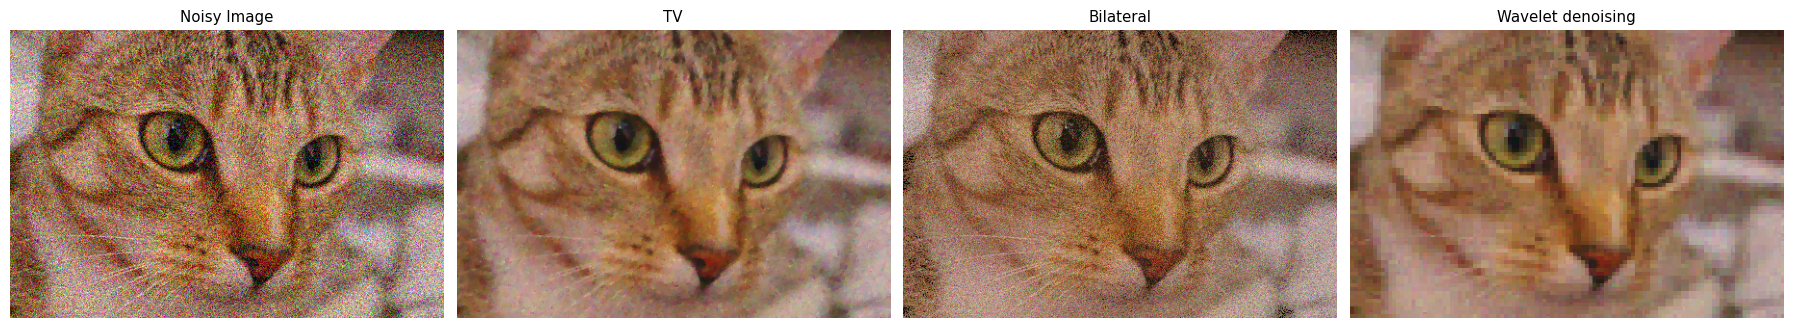

In [20]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)

fig, ax = plt.subplots(ncols=4, figsize=(18, 15),sharex=True, sharey=True)

plt.gray()

noisy_im = noisy1

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy_im, channel_axis=-1, average_sigmas=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0].imshow(noisy_im)
ax[0].axis('off')
ax[0].set_title('Noisy Image')

ax[1].imshow(denoise_tv_chambolle(noisy_im, weight=0.1, channel_axis=-1))
ax[1].axis('off')
ax[1].set_title('TV')

ax[2].imshow(denoise_bilateral(noisy_im, sigma_color=0.05, sigma_spatial=15, channel_axis=-1))
ax[2].axis('off')
ax[2].set_title('Bilateral')

ax[3].imshow(denoise_wavelet(noisy_im, channel_axis=-1, rescale_sigma=True))
ax[3].axis('off')
ax[3].set_title('Wavelet denoising')

fig.tight_layout()

plt.show()